# Slice Sampler vs. Hybrid Slice Sampler

The following code compares trajectories and performances of the Slice Sampler (with the RWM algorithm as subroutine) with those of the Hybrid Slice Sampler (with the Skipping Sampler as subroutine).
We consider a mixture of $7$ Gaussian distributions in dimension $d=5$ as the target distribution. The following code has been used to generate Figure 2 and Table 1.

In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
from numpy import matlib as mb
from scipy.stats import special_ortho_group #needed for random rotations

def GaussianPDF(x, mu, detSigma, invSigma):
    """
    GaussianPDF returns, up to a constant factor, the value of the multivariate d-dimensional 
    Gaussian probability density with mean mu and covariance matrix Sigma evaluated at the point x.
    
    Parameters
    ----------
    :x: is the d-dimensional vector describing the point at which the density is evaluated
    :mu: is the d-dimensional vector describing the mean of the Gaussian distribution
    :detSigma: is the determinant of the covariance matrix Sigma
    :invSigma: is the inverse of the covariance matrix Sigma
    
    Note that the density does not account for the normalization constant (2 * np.pi) ** (-d/2)
    
    Returns
    ----------
    The Gaussian density evaluated at the point x
    """ 
    
    return (detSigma ** (-1/2)) * np.exp(-.5 * (x - mu).T @ invSigma @ (x - mu))

def LogTarget(x, d, NumberOfModes, ModeLocations, invSigmas, detSigmas, Weights):
    """
    LogTarget returns the density of the mixture of several multivariate d-dimensional Gaussian 
    distributions evaluated at the point x.
    
    Parameters
    ----------
    :x: is the d-dimensional vector describing the point at which the density is evaluated
    :d: is the dimension of the probability space
    :NumberOfModes: is the number of Gaussian distribution in the mixture
    :ModeLocations: is the NumberOfModes x d array containing the mean of each of the NumberOfModes Gaussian distributions
    :detSigmas: is a NumberOfModes array containing the value of the determinants of the covariance matrices of the various Gaussian distributions
    :invSigmas: is a (NumberOfModes * d) x (NumberOfModes * d) matrix whose d x d diagonal blocks are the inverse of the covariance matrices of the various Gaussian distributions 
    :Weights: is the NumberOfModes array containing the weights given in the mixture to the various Gaussian distributions
    
    Note that the density does not account for the normalization constant (2 * np.pi) ** (-d/2)
    
    Returns
    ----------
    The logarithm of the the mixtured Gaussian density evaluated at the point x
    """ 
        
    return np.log(np.average([GaussianPDF(x, ModeLocations[i], detSigmas[i], invSigmas[(i*d):((i+1)*d),(i*d):((i+1)*d)] ) for i in range(NumberOfModes)], weights=Weights))
        
def GenerateDirection(d, PropCovariance):
    """
    GenerateDirection returns a random direction in R^d sampled according to a multivariate zero-mean 
    Gaussian distribution and given covariance matrix.
    
    Parameters
    ----------
    :d: is the dimension of the probability space
    :PropCovariance: is the covariance matrix of the proposal distribution
        
    Returns
    ----------
    A d-dimensional vector of unit norm sampled
    """
    
    v = np.random.multivariate_normal(np.zeros(d), PropCovariance)
    return v / np.linalg.norm(v)

def GenerateDistance(d, Direction, InvCov):
    """
    GenerateDistance returns a random distance sampled from the proposal density conditionally on a given direction
    
    Parameters
    ----------
    :d: is the dimension of the probability space
    :Direction: is the d-dimensional array describing the direction
    :invCov: is the inverse of the covariance matrix of the Gaussian proposal deensity
    
    GenerateDistance assumes that the proposal density is Gaussian.
    
    Returns
    ----------
    A positive scalar descriibing the random distance
    """
    
    return (Direction.T @ InvCov @ Direction)**(-1/2) * np.sqrt(np.random.chisquare(d))

# Generate random target distribution

The next cells generates a Gaussian mixture as target distribution. It samples ```NumberOfModes``` modes uniformly at random in the ```d```-dimensional cube $[- BoxParameter , BoxParameter]^d $, which become the centers of the Gaussian distribution in the mixture. Each Gaussian distribution can be given a weight in the mixture and a variance parameter, which are stored in the vectors ```Weights``` and ```Scaling```, respectively.
In this instance, we consider a Gaussian mixture in dimension $d = 5$, with $7$ modes sampled in the hypercube $[- 10 , 10]^d $. The weights are taken to be all equal and the variance parameters are all taken to be equal to $1$.

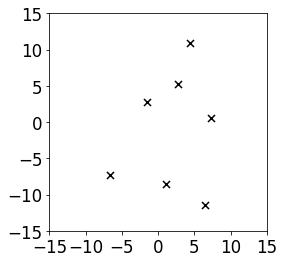

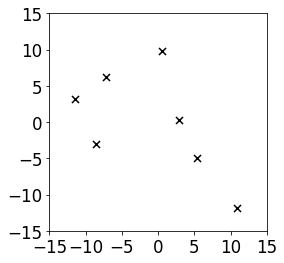

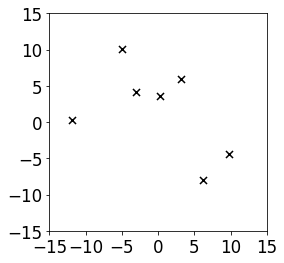

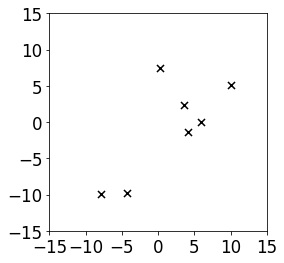

In [3]:
d = 5 #dimension
NumberOfModes = 7 # How many Gaussians are in the mixture.
BoxParameter = 12 # Defining the space [-BoxParameter,BoxParameter]^d

# Generate at random the locations of means of Gaussians by placing them uniformly at random in the given box [-BoxParameter,BoxParameter]^d
np.random.seed(10) # For reproducibility
ModeLocations = np.random.uniform(low=-BoxParameter, high=BoxParameter, size=(NumberOfModes,d)) 
CoordinateMeans = np.mean(ModeLocations, axis=0)

# Specify the weights (which need to some to one) to create a weighted mixture of Gaussians
Weights = np.ones(NumberOfModes)/NumberOfModes

# Random weights are also possible, but they need to be rescaled to sum up to one.
# Weights = np.random.rand(NumberOfModes)
# Weights = Weights / np.sum(Weights)

# Specify the width of each of the Gaussian distributions in the mixture
Scaling = np.ones(NumberOfModes)
# Random scalings are also possible
# Scaling = np.random.exponential(4, NumberOfModes)

# Generate random covariance matrices for the Gaussian mixture and store them as diagonal blocks
# into a single giant block-diagonal matri
invSigmas = np.zeros((NumberOfModes*d,NumberOfModes*d))
detSigmas = np.zeros(NumberOfModes)
for i in range(NumberOfModes):
    # Random rotation matrix is sampled
    R = special_ortho_group.rvs(d)
    # The inverse of each covariance matrix is obtained directly by taking the diagonal matrix with
    # the reciprocals of the scaling terms and then applying a random rotation 
    invSigmas[(i*d):((i+1)*d),(i*d):((i+1)*d)] = R @ np.linalg.inv(Scaling[i]*np.identity(d)) @ R.T
    # The determinant of the i-th covariance matrix is calculated
    detSigmas[i] = Scaling[i]**d 

for c in range(d-1):
    fontsize = 24
    fig, ax = plt.subplots()
    plt.scatter(ModeLocations[:,c], ModeLocations[:,c+1], marker='x', color='black', s=50)
    plt.xlim(-BoxParameter-3, BoxParameter+3)
    plt.ylim(-BoxParameter-3, BoxParameter+3)
    fig.set_size_inches(4,4)
    plt.gca().set_aspect('equal')
    plt.xticks(fontsize=0.7*fontsize)
    plt.yticks(fontsize=0.7*fontsize)
    plt.show()

# Classical Slice Sampler using RWM algorithm

For the Gaussian mixture distribution defined above, we perform 100 runs of the RWM algorithm (each being a trajectory of 20000 steps) using a Gaussian proposal density has been tuned as to achieve an average acceptance rate of 0.2354 (see Appendix below). 

In [4]:
n_runs = 100
steps = 20000

# Proposal distribution (tuned as to achieve an average acceptance rate of 0.2354, see Appendix)
PropVar = 1.45
PropCovariance = PropVar*np.identity(d)
InvCov = np.linalg.inv(PropCovariance)

# Variable allocations
TrajectoryRW = np.zeros((n_runs, steps, d)) # Stores the trajectory for every run
AvgAcceptanceRatesRW = np.zeros(n_runs) # Average acceptance rates per run
TotalTargetEvaluationsRW = np.zeros(n_runs) # Number of target evaluations per run
ESJDRW = np.zeros((n_runs,d)) # Expected squared jump distance for all coordinates
EstimatedMeansRW = np.zeros((n_runs,d)) # Estimated means for each run
MSERW = np.zeros(n_runs) # Mean squared errors in estimated the mean of each coordinate

for k in range(n_runs):
    
    t = time.time()
    
    # Run-specific variable initialization
    np.random.seed(k)
    
    # Sample the starting point from the Gaussian mixture in two steps:
    # 1) Choose a random mode proportionally to Weights
    # 2) Sample a point from the selected mode
    ModeIndex = np.random.choice(NumberOfModes, p=Weights)
    Location = np.random.multivariate_normal(ModeLocations[ModeIndex], Scaling[ModeIndex]*np.identity(d))
    
    AcceptedStepsRW = np.zeros(steps, dtype=int) # Keeps track of whether a step was accepted (1) or not (0)
    LogCoins = np.log(np.random.rand(steps)) # Pre-sample all accept-reject coins required in the slice sampler ahead of time 
    TargetEvaluationsRW = 0
    
    # Trajectory generation
    for i in range(steps):
        IsOutside = True # tracks if we are outside (True) or inside (False) the target slice
        TrajectoryRW[k,i] = Location # Store current point in the trajectory
        
        # Samples the slice level at random
        SliceLevel = LogCoins[i] + LogTarget(Location, d, NumberOfModes, ModeLocations, invSigmas, detSigmas, Weights)
        
        # Gaussian RW proposal that, to mirror the Skipping Sampler, is performed in two steps:
        # 1) sampling a direction 
        # 2) sampling a distance conditionally on the direction sampled in (1)
        Direction = GenerateDirection(d, PropCovariance) # pick a random direction
        IntermediateLocation = Location + GenerateDistance(d, Direction, InvCov)*Direction
        
        # Check if the slice has been hit and, in that case, accepts automatically the proposal
        TargetEvaluationsRW += 1
        if LogTarget(IntermediateLocation, d, NumberOfModes, ModeLocations, invSigmas, detSigmas, Weights) >= SliceLevel:
            IsOutside = False
            Location = IntermediateLocation
            AcceptedStepsRW[i] = 1
    
    # Calculate the statistics of the current trajectory
    AvgAcceptanceRatesRW[k] = np.mean(AcceptedStepsRW)
    EstimatedMeansRW[k] = np.mean(TrajectoryRW[k],axis=0)
    ESJDRW[k] = np.mean([(TrajectoryRW[k,j+1] - TrajectoryRW[k,j])**2 for j in range(len(TrajectoryRW[k])-1)], axis=0)
    TotalTargetEvaluationsRW[k] = TargetEvaluationsRW
    
    elapsed = time.time() - t
    print("Run",k,"Time=",np.round(elapsed,3),"sec")
    
# Compute and display global statistics across multiple runs
MSERW = (EstimatedMeansRW - np.tile(CoordinateMeans, (n_runs,1)))**2
print("Average Acceptance Rate =", np.mean(AvgAcceptanceRatesRW))
print("Average Number of Evaluations =", np.mean(TotalTargetEvaluationsRW))
# print("ESJD = ", ESJDRW)
# print("MSE = ", MSERW)

Run 0 Time= 5.568 sec
Run 1 Time= 5.644 sec
Run 2 Time= 6.075 sec
Run 3 Time= 5.66 sec
Run 4 Time= 5.448 sec
Run 5 Time= 5.477 sec
Run 6 Time= 5.848 sec
Run 7 Time= 5.72 sec
Run 8 Time= 5.746 sec
Run 9 Time= 5.589 sec
Run 10 Time= 5.573 sec
Run 11 Time= 5.539 sec
Run 12 Time= 5.471 sec
Run 13 Time= 6.066 sec
Run 14 Time= 5.493 sec
Run 15 Time= 5.53 sec
Run 16 Time= 5.644 sec
Run 17 Time= 5.646 sec
Run 18 Time= 5.879 sec
Run 19 Time= 6.786 sec
Run 20 Time= 5.761 sec
Run 21 Time= 5.833 sec
Run 22 Time= 5.824 sec
Run 23 Time= 5.836 sec
Run 24 Time= 5.569 sec
Run 25 Time= 5.643 sec
Run 26 Time= 5.629 sec
Run 27 Time= 5.574 sec
Run 28 Time= 5.2 sec
Run 29 Time= 5.354 sec
Run 30 Time= 5.239 sec
Run 31 Time= 5.754 sec
Run 32 Time= 5.761 sec
Run 33 Time= 5.72 sec
Run 34 Time= 6.023 sec
Run 35 Time= 5.584 sec
Run 36 Time= 6.572 sec
Run 37 Time= 6.528 sec
Run 38 Time= 6.431 sec
Run 39 Time= 8.294 sec
Run 40 Time= 6.551 sec
Run 41 Time= 5.442 sec
Run 42 Time= 5.373 sec
Run 43 Time= 5.84 sec
Run 4

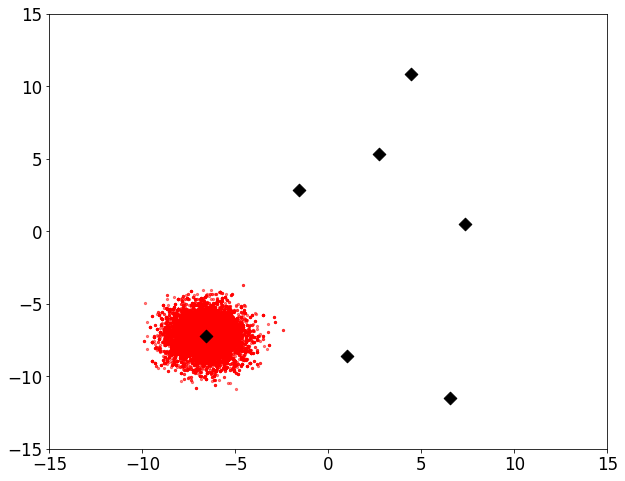

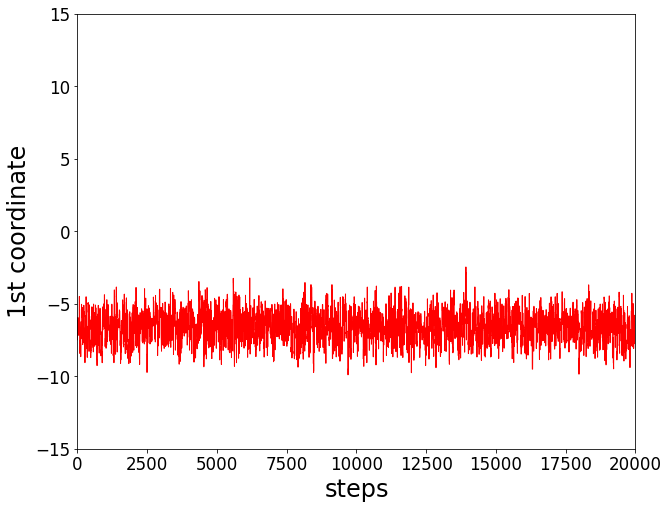

In [46]:
k = 90 # run selected for generating figures

fontsize=24
plt.scatter(TrajectoryRW[k,:,0], TrajectoryRW[k,:,1], s=markersize, alpha=0.5, color='red')
plt.scatter(ModeLocations[:,0],ModeLocations[:,1], marker='D', color='black', s=80)
fig = plt.gcf()
fig.set_size_inches(10,8)
plt.xlim(-BoxParameter-3, BoxParameter+3)
plt.ylim(-BoxParameter-3, BoxParameter+3)
plt.xticks(fontsize=0.7*fontsize)
plt.yticks(fontsize=0.7*fontsize)
plt.savefig('SliceSampler_RWM_20000steps.png', dpi=300, bbox_inches='tight', pad_inches = 0.1)
plt.show()

plt.plot(TrajectoryRW[k,:,0], linewidth=1, color='red')
fig = plt.gcf()
fig.set_size_inches(10,8)
plt.ylim(-15, 15)
plt.xlim(0, len(Trajectory[k,:,0]))
plt.xlabel('steps', fontsize=fontsize)
plt.ylabel('1st coordinate', fontsize=fontsize)
plt.xticks(fontsize=0.7*fontsize)
plt.yticks(fontsize=0.7*fontsize);
plt.savefig('SliceSampler_RWM_20000steps_1stcoordinate.png', dpi=300, bbox_inches='tight', pad_inches = 0.1)
plt.show()

# Hybrid Slice Sampler

For the same Gaussian mixture distribution defined above, we perform 100 runs of the Hybrid Slice Sampler (each being a trajectory of 20000 steps) using a Gaussian proposal density has been tuned as to achieve an average acceptance rate of 0.2354 in the RWM case (see Appendix below). 
The halting index has been set to be constantly equal to $K=15$.

In [5]:
HaltingIndex = 15
n_runs = 100
steps = 20000

# Proposal distribution (tuned for the RWM to achieve an average acceptance rate of 0.2354, see Appendix)
PropVar = 1.45
PropCovariance = PropVar*np.identity(d)
InvCov = np.linalg.inv(PropCovariance)

# Variable allocations
Trajectory = np.zeros((n_runs, steps, d)) # Keeps track of the trajectory for every run
AvgAcceptanceRates = np.zeros(n_runs) # Average acceptance rates per run
SkipsLength = np.zeros((n_runs,steps), dtype=int) # Keeps track of length of the accepted skips
TotalSkips = np.zeros(n_runs,dtype=int) # Counts total amount of skips per run
TotalTargetEvaluations = np.zeros(n_runs, dtype=int) # Number of target evaluations per run
ESJD = np.zeros((n_runs,d)) # Expected squared jump distance for all coordinates
EstimatedMeans = np.zeros((n_runs,d)) # Estimated means for each run
MSE = np.zeros(n_runs) # Mean squared errors in estimated the mean of each coordinate

for k in range(n_runs):
    
    t = time.time()
    
    # Run-specific variable initialization
    np.random.seed(k)
    
    # Sample the starting point from the Gaussian mixture in two steps:
    # 1) Choose a random mode proportionally to Weights
    # 2) Sample a point from the selected mode
    ModeIndex = np.random.choice(NumberOfModes, p=Weights)
    Location = np.random.multivariate_normal(ModeLocations[ModeIndex], Scaling[ModeIndex]*np.identity(d))
    
    Locations = np.zeros((steps, d)) # Allocate array for the whole trajectory
    AcceptedSteps = np.zeros(steps, dtype=int) # Keeps track of whether a step was accepted (1) or not (0)
    SkipsCounter = np.zeros(steps, dtype=int) # Keeps track of the number of skips in each skipping excursion for each run
    SkipFlag = np.zeros(steps, dtype=int) # Keeps track of whether a move was RW (0) or a true skipping move (1)
    LogCoins = np.log(np.random.rand(steps)) # Pre-sample all accept-reject coins required in the slice sampler ahead of time 
    TargetEvaluations = 0
    
    # Trajectory generation
    for i in range(steps):
        
        IsOutside = True # This variable tracks if we are outside (True) or inside (False) the target slice
        Trajectory[k, i] = Location # Store the current point in the trajectory
        # Sample the level at which the new slice should be created
        SliceLevel = LogCoins[i] + LogTarget(Location, d, NumberOfModes, ModeLocations, invSigmas, detSigmas, Weights)
        
        IntermediateLocation = Location # State that keeps updating
        Direction = GenerateDirection(d, PropCovariance) # Pick a random direction
        
        # Keep extending the proposal by skipping in the same direction until either:
        # - the halting index is reached
        # - the target slice has been hit
        
        while (SkipsCounter[i] < HaltingIndex and IsOutside):
            IntermediateLocation = IntermediateLocation + GenerateDistance(d, Direction, InvCov)*Direction
            SkipsCounter[i] += 1
            # Check if the slice has been hit and in that case accept automatically
            TargetEvaluations += 1
            if LogTarget(IntermediateLocation, d, NumberOfModes, ModeLocations, invSigmas, detSigmas, Weights) >= SliceLevel:
                IsOutside = False
                Location = IntermediateLocation
                AcceptedSteps[i] = 1
                if SkipsCounter[i] > 1:
                    SkipFlag[i] = 1
                    SkipsLength[k,i] = SkipsCounter[i]
        
    # Calculate trajectory statistics for the current trajectory
    AvgAcceptanceRates[k] = np.mean(AcceptedSteps)
    TotalSkips[k] = np.sum(SkipFlag)
    EstimatedMeans[k] = np.mean(Locations,axis=0)
    ESJD[k] = np.mean([(Trajectory[k,j+1] - Trajectory[k,j])**2 for j in range(len(Trajectory[k])-1)], axis=0)
    TotalTargetEvaluations[k] = TargetEvaluations
    
    elapsed = time.time() - t
    print("Run",k,"Time=",np.round(elapsed,3),"sec","Accepted skips",TotalSkips[k],"Unique skipping lengths",np.unique(SkipsLength[k]))

# Compute and display global statistics across multiple runs
MSE = (EstimatedMeans-np.tile(CoordinateMeans,(n_runs,1)))**2
print("Average Acceptance Rate =", np.mean(AvgAcceptanceRates))
print("Average Number of Evaluations =", np.mean(TotalTargetEvaluations))
print("Total number of skips in each run =", TotalSkips)
# print("ESJD = ", ESJDRW)
# print("MSE = ", MSERW)


<ipython-input-1-6ebf65465f12>:50: RuntimeWarning: divide by zero encountered in log
  return np.log(np.average([GaussianPDF(x, ModeLocations[i], detSigmas[i], invSigmas[(i*d):((i+1)*d),(i*d):((i+1)*d)] ) for i in range(NumberOfModes)], weights=Weights))


Run 0 Time= 23.627 sec Accepted skips 17 Unique skipping lengths [0 2 3 4 6 7]
Run 1 Time= 22.734 sec Accepted skips 13 Unique skipping lengths [ 0  3  4  5  6  7 11]
Run 2 Time= 23.546 sec Accepted skips 24 Unique skipping lengths [0 2 3 4 5 8 9]
Run 3 Time= 23.171 sec Accepted skips 15 Unique skipping lengths [0 3 4 5 6 7 8 9]
Run 4 Time= 23.585 sec Accepted skips 16 Unique skipping lengths [0 2 3 5 6 7]
Run 5 Time= 23.83 sec Accepted skips 23 Unique skipping lengths [0 2 3 4 5 6 7]
Run 6 Time= 22.901 sec Accepted skips 5 Unique skipping lengths [ 0  6  7  8 10]
Run 7 Time= 23.947 sec Accepted skips 20 Unique skipping lengths [0 2 3 4]
Run 8 Time= 23.283 sec Accepted skips 5 Unique skipping lengths [0 3 4 7 8]
Run 9 Time= 24.006 sec Accepted skips 30 Unique skipping lengths [0 2 3 4 5]
Run 10 Time= 23.392 sec Accepted skips 16 Unique skipping lengths [ 0  3  4  5  6  7 11]
Run 11 Time= 23.761 sec Accepted skips 12 Unique skipping lengths [ 0  2  3  4  5  6  7  8 10]
Run 12 Time= 24.2

Run 99 Time= 27.148 sec Accepted skips 13 Unique skipping lengths [0 2 3 4 5 7 8]
Average Acceptance Rate = 0.23684800000000003
Average Number of Evaluations = 233733.75
Total number of skips in each run = [17 13 24 15 16 23  5 20  5 30 16 12  7 14 24 35  2 19 23 17 22 27 22 10
  7 11  7 20 20 15  8 20  8 27 18 23 28 15 20 23 15 13 22 19  8 15 18 22
 15 21 19 25 18 17 18 12  9 24  9 13 22 17 14 24 22  7 14 15 17 19 14 18
 21 16 11 13 14  7  4 11 12  7 12  3 25 25 25 27 35  8 33  1  1 20 13 14
 15 16 10 13]


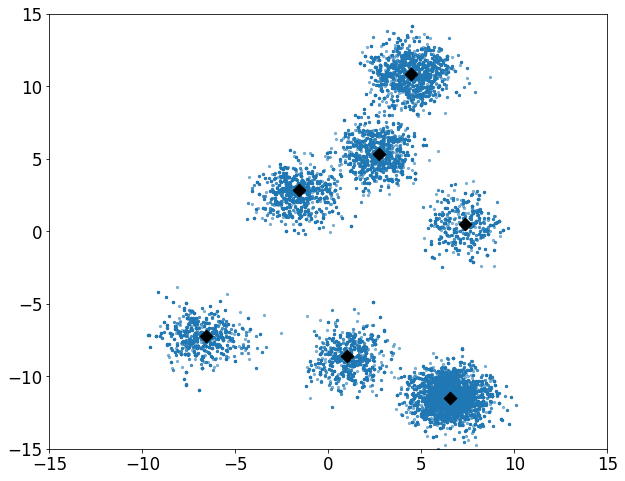

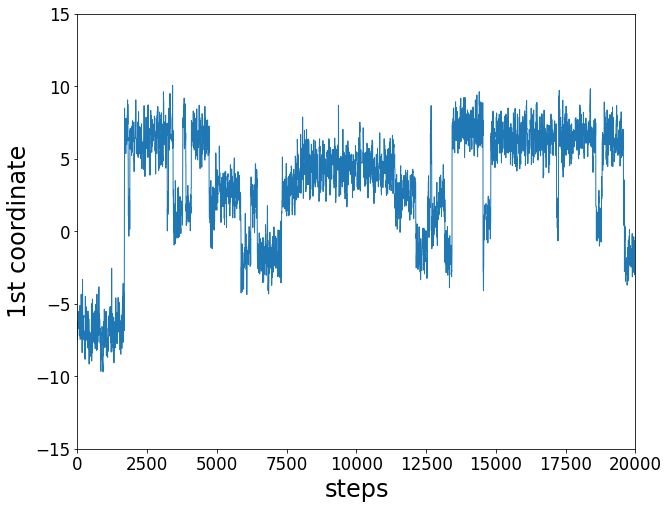

In [44]:
k = 90 # run selected for generating figures

fontsize=24
plt.scatter(Trajectory[k,:,0], Trajectory[k,:,1], s=markersize, alpha=0.5)
plt.scatter(ModeLocations[:,0],ModeLocations[:,1], marker='D', color='black', s=80)
fig = plt.gcf()
fig.set_size_inches(10,8)
plt.xlim(-BoxParameter-3, BoxParameter+3)
plt.ylim(-BoxParameter-3, BoxParameter+3)
plt.xticks(fontsize=0.7*fontsize)
plt.yticks(fontsize=0.7*fontsize)
plt.savefig('SliceSampler_Skipping_20000steps.png', dpi=300, bbox_inches='tight', pad_inches = 0.1)
plt.show()

plt.plot(Trajectory[k,:,0], linewidth=1)
fig = plt.gcf()
fig.set_size_inches(10,8)
plt.ylim(-15, 15)
plt.xlim(0, len(Trajectory[k,:,0]))
plt.xlabel('steps', fontsize=fontsize)
plt.ylabel('1st coordinate', fontsize=fontsize)
plt.xticks(fontsize=0.7*fontsize)
plt.yticks(fontsize=0.7*fontsize);
plt.savefig('SliceSampler_Skipping_20000steps_1stcoordinate.png', dpi=300, bbox_inches='tight', pad_inches = 0.1)
plt.show()

# Comparison between RWM and Skipping sampler

These performance metric are averaged over 100 runs.

In [33]:
print("Average Acceptance Rate RWM =", AvgAcceptanceRatesRW)
print("Average Acceptance Rate Skipping sampler =", AvgAcceptanceRates)
print("Total number of skip moves =", TotalSkips)

#print(TotalTargetEvaluationsRW)
#print(TotalTargetEvaluations)
print("Ratio between the number of target evaluations =", TotalTargetEvaluations/TotalTargetEvaluationsRW)

print("Coordinate-wise MSE RWM =", np.mean(MSERW, axis=0))
print("Coordinate-wise MSE Skipping sampler =", np.mean(MSE, axis=0))
print("Coordinate-wise MSE reduction =", np.mean(MSERW, axis=0)/np.mean(MSE, axis=0))

Average Acceptance Rate RWM = [0.2373  0.23335 0.23745 0.23605 0.23905 0.23825 0.2308  0.23485 0.23365
 0.23145 0.2393  0.23395 0.24165 0.24045 0.2395  0.2376  0.22775 0.24315
 0.2437  0.23615 0.23465 0.2426  0.2338  0.237   0.2381  0.2329  0.2382
 0.23295 0.2391  0.2384  0.23715 0.2319  0.2314  0.23755 0.23755 0.2361
 0.23075 0.24115 0.23685 0.2366  0.2315  0.2421  0.23915 0.2375  0.2381
 0.22995 0.23435 0.241   0.2304  0.23825 0.2344  0.23405 0.23695 0.23885
 0.23225 0.2366  0.23815 0.24545 0.2352  0.2376  0.2398  0.2313  0.2405
 0.23305 0.24035 0.23245 0.2363  0.23265 0.24025 0.2372  0.23265 0.2378
 0.23085 0.2356  0.23135 0.23445 0.23675 0.24145 0.2299  0.23775 0.23475
 0.238   0.23775 0.2402  0.2338  0.23795 0.2388  0.23845 0.22935 0.2366
 0.2352  0.23635 0.23665 0.23995 0.2355  0.243   0.23145 0.23345 0.23335
 0.23335]
Average Acceptance Rate Skipping sampler = [0.24245 0.2394  0.2412  0.238   0.23825 0.2331  0.2333  0.23485 0.23455
 0.23495 0.24275 0.2343  0.2318  0.23245 0.2343

# Appendix: tuning of the Gaussian proposal for RWM algorithm

In [45]:
tuning_runs = 30
steps = 10000

# Proposal distribution
PropVar = 1.45
PropCovariance = PropVar*np.identity(d)
InvCov = np.linalg.inv(PropCovariance)

AverageAcceptanceRate = np.zeros(tuning_runs)

for k in range(tuning_runs):
    
    t = time.time()
    
    # Run-specific variable initialization
    np.random.seed(k)
    AcceptedStepsRW = np.zeros(steps, dtype=int) # Keeps track of whether a step was accepted (1) or not (0)
    LogCoins = np.log(np.random.rand(steps)) # Pre-sample all accept-reject coins required in the slice sampler ahead of time 
    
    # Sample the starting point from the Gaussian mixture in two steps:
    # 1) Choose a random mode proportionally to Weights
    # 2) Sample a point from the selected mode
    ModeIndex = np.random.choice(NumberOfModes, p=Weights)
    Location = np.random.multivariate_normal(ModeLocations[ModeIndex], Scaling[ModeIndex]*np.identity(d))
    
    # Trajectory generation
    for i in range(steps):
        IsOutside = True # tracks if we are outside (True) or inside (False) the target slice
  
        # Samples the slice level at random
        SliceLevel = LogCoins[i] + LogTarget(Location, d, NumberOfModes, ModeLocations, invSigmas, detSigmas, Weights)
        
        # Gaussian RW proposal that, to mirror the Skipping Sampler, is performed in two steps:
        # 1) sampling a direction 
        # 2) sampling a distance conditionally on the direction sampled in (1)
        Direction = GenerateDirection(d, PropCovariance) # pick a random direction
        IntermediateLocation = Location + GenerateDistance(d, Direction, InvCov)*Direction
        
        # Check if the slice has been hit and, in that case, accepts automatically the proposal
        if LogTarget(IntermediateLocation, d, NumberOfModes, ModeLocations, invSigmas, detSigmas, Weights) >= SliceLevel:
            IsOutside = False
            Location = IntermediateLocation
            AcceptedStepsRW[i] = 1
    
    AverageAcceptanceRate[k] = np.mean(AcceptedStepsRW)
    elapsed = time.time() - t
    
    print("Run",k," Time = ",np.round(elapsed,3),"sec", "Average Acceptance Rate RW =", AverageAcceptanceRate[k])

np.mean(AverageAcceptanceRate)

Run 0  Time =  2.921 sec Average Acceptance Rate RW = 0.2388
Run 1  Time =  2.842 sec Average Acceptance Rate RW = 0.2259
Run 2  Time =  2.891 sec Average Acceptance Rate RW = 0.2407
Run 3  Time =  2.912 sec Average Acceptance Rate RW = 0.234
Run 4  Time =  2.928 sec Average Acceptance Rate RW = 0.2333
Run 5  Time =  3.167 sec Average Acceptance Rate RW = 0.2311
Run 6  Time =  3.108 sec Average Acceptance Rate RW = 0.2264
Run 7  Time =  2.671 sec Average Acceptance Rate RW = 0.2384
Run 8  Time =  2.743 sec Average Acceptance Rate RW = 0.2404
Run 9  Time =  2.663 sec Average Acceptance Rate RW = 0.2345
Run 10  Time =  2.669 sec Average Acceptance Rate RW = 0.2473
Run 11  Time =  2.695 sec Average Acceptance Rate RW = 0.2299
Run 12  Time =  2.72 sec Average Acceptance Rate RW = 0.2354
Run 13  Time =  2.748 sec Average Acceptance Rate RW = 0.2398
Run 14  Time =  2.79 sec Average Acceptance Rate RW = 0.2295
Run 15  Time =  2.721 sec Average Acceptance Rate RW = 0.2378
Run 16  Time =  2.706

0.2351233333333333